In [49]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import cv2
import matplotlib.pyplot as plt
import numpy as np
import ternausnet.models
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.augmentations.transforms as T
from albumentations.pytorch import ToTensorV2

from segmentation_models_pytorch.losses import DiceLoss 
import segmentation_models_pytorch as smp
import PIL
import glob

cudnn.benchmark = True

In [50]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

In [51]:
all_img_paths = glob.glob("data/test/img/*")+glob.glob("data/train/img/*")+glob.glob("data/val/img/*")
correct_images_paths = [i for i in all_img_paths if cv2.imread(i) is not None]

random.seed(33)
random.shuffle(correct_images_paths)

train_images_paths = correct_images_paths[:820]
val_images_paths = correct_images_paths[820:-10]
test_images_paths = correct_images_paths[-10:]

print(len(train_images_paths), len(val_images_paths), len(test_images_paths))

820 250 10


data/train/img\f_305_G.png
data/train/segm\f_305_G.png


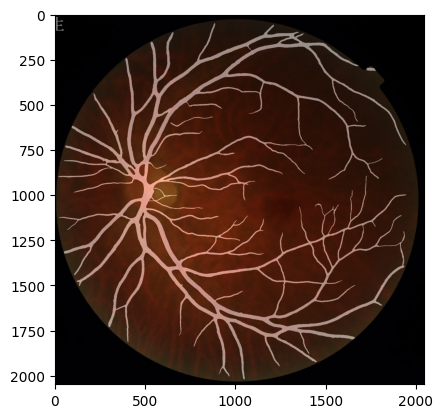

In [36]:
img_xd = test_images_paths[0]
image = cv2.imread(img_xd)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = PIL.Image.fromarray(image)
mask_path = str(img_xd).replace("/img\\", "/segm\\")
if mask_path.split('\\')[-1][0] !='f' and mask_path.split('\\')[-1].split('.')[-1] == 'jpg':
    mask_path = mask_path.replace('.jpg', '.tif').replace('est', '')
mask = cv2.imread(mask_path)
mask = PIL.Image.fromarray(mask)
print(img_xd)
print(mask_path)
plt.imshow(image)
plt.imshow(mask, alpha=0.5)

In [52]:
def display_image_grid(images_paths, predicted_masks=None, predicted_probabilities=None):
    cols = 3 if predicted_masks else 2
    if predicted_probabilities: cols += 1
    rows = len(images_paths)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_path in enumerate(images_paths):
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask_path = str(image_path).replace("/img\\", "/segm\\")
        if mask_path.split('\\')[-1][0] !='f' and (mask_path.split('\\')[-1].split('.')[-1] == 'jpg' or mask_path.split('\\')[-1].split('.')[-1] == 'JPG'):
            mask_path = mask_path.replace('.jpg', '.tif').replace('.JPG', '.tif')
        mask = plt.imread(mask_path)
        # mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
        if predicted_probabilities:
            probability = predicted_probabilities[i]
            ax[i, 3].imshow(probability, interpolation="nearest")
            ax[i, 3].set_title("Predicted probability")
            
    plt.tight_layout()
    plt.show()

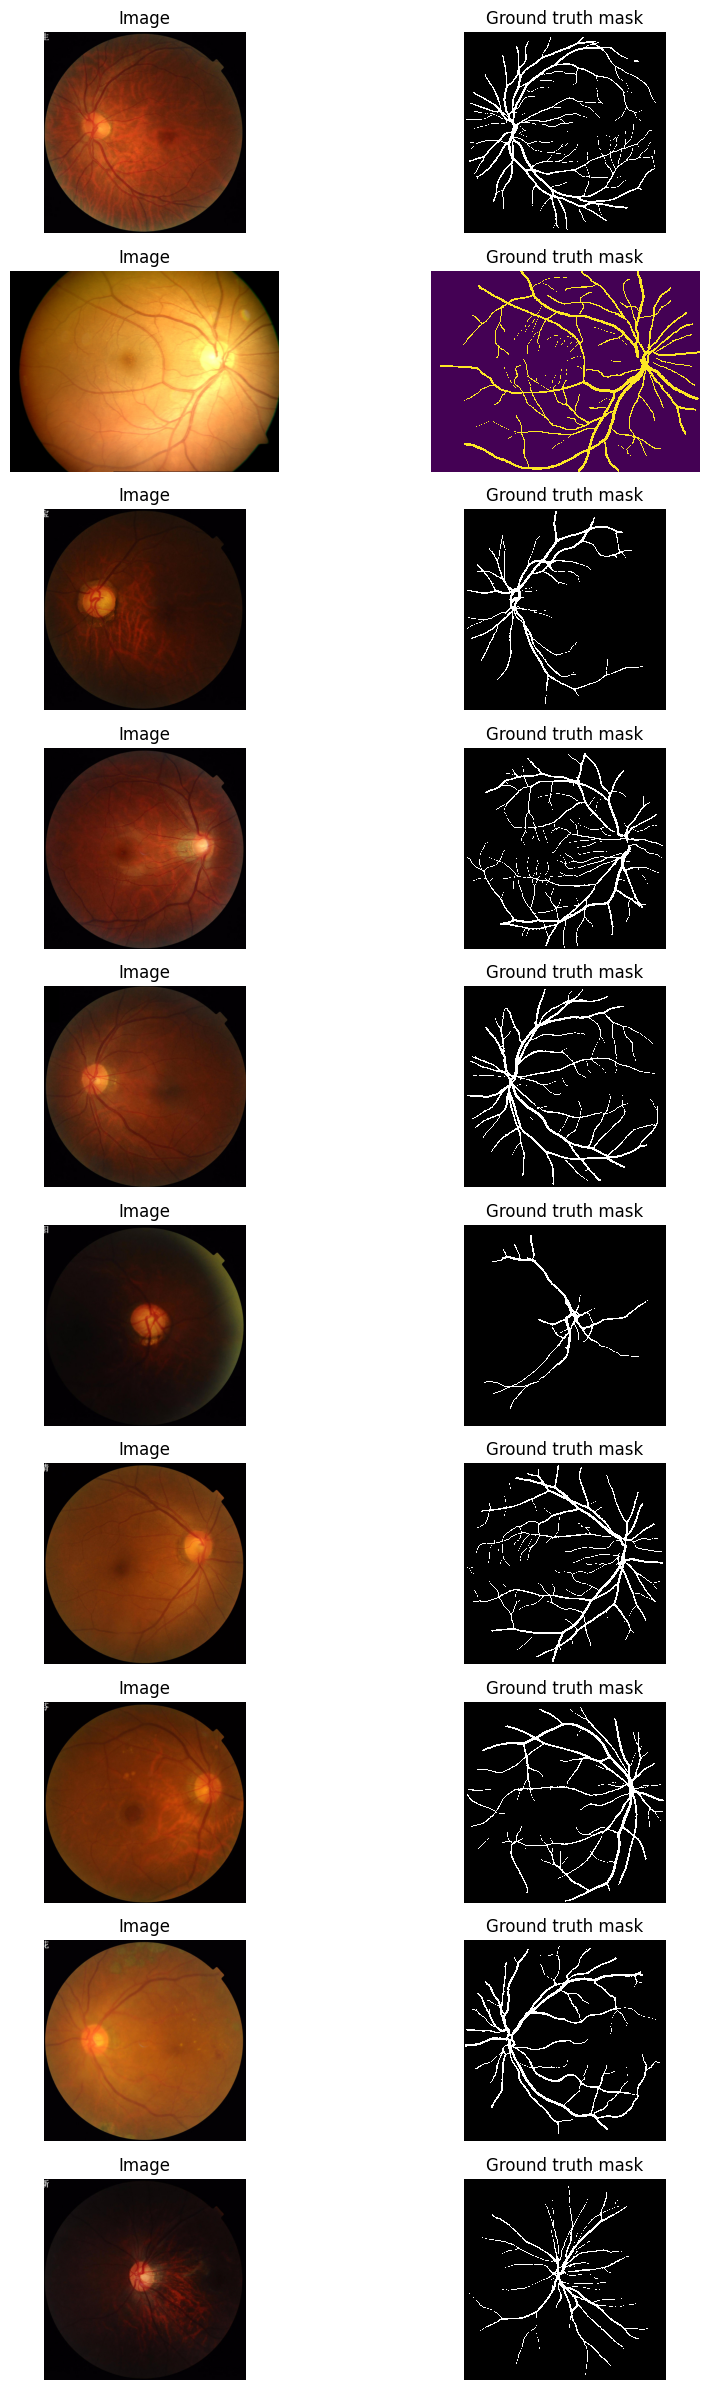

In [38]:
display_image_grid(test_images_paths)

In [58]:
model_name = "UNet11"
batch_size = 9
epochs_num = 35
img_size = 256

params = {
    "model": model_name,
    "device": "cuda",
    "lr": 0.001,
    "batch_size": batch_size,
    "num_workers": 0,
    "epochs": epochs_num,
    "img_size" : img_size,
}

In [59]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 255] = 1
    return mask

class SegmDataset(Dataset):
    def __init__(self, images_paths, transform=None):
        self.images_paths = images_paths
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image_path = self.images_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              
        mask_path = str(image_path).replace("/img\\", "/segm\\")
        if mask_path.split('\\')[-1][0] !='f' and (mask_path.split('\\')[-1].split('.')[-1] == 'jpg' or mask_path.split('\\')[-1].split('.')[-1] == 'JPG'):
            mask_path = mask_path.replace('.jpg', '.tif').replace('.JPG', '.tif')
        mask = plt.imread(mask_path)
        mask = preprocess_mask(mask)        
        
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        if len(mask.shape) == 3:
            mask=mask[:,:, 0]
        return image, mask

train_transform = A.Compose([
        A.Resize(params["img_size"],params["img_size"]),
        # A.Rotate(limit=360, border_mode=0),
        # T.ColorJitter(brightness=0.2, contrast=0.2, hue=(-0.025,0.025)),
        # A.VerticalFlip(),
        # A.HorizontalFlip(),
        # A.RandomResizedCrop(params["img_size"],params["img_size"], p=0.5),
        T.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666]),
        ToTensorV2()
    ])
train_dataset = SegmDataset(train_images_paths, transform=train_transform,)

val_transform = A.Compose([
        A.Resize(params["img_size"], params["img_size"]),
        T.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666]),
        ToTensorV2()
    ])
val_dataset = SegmDataset(val_images_paths, transform=val_transform,)

In [60]:
def visualize_augmentations(dataset, idx=0, samples=2):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (T.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=3, figsize=(10, 8))
    for i in np.arange(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 2].imshow(image)
        ax[i, 2].imshow(mask, interpolation="nearest", alpha=0.5)
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 2].set_title("Blend")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

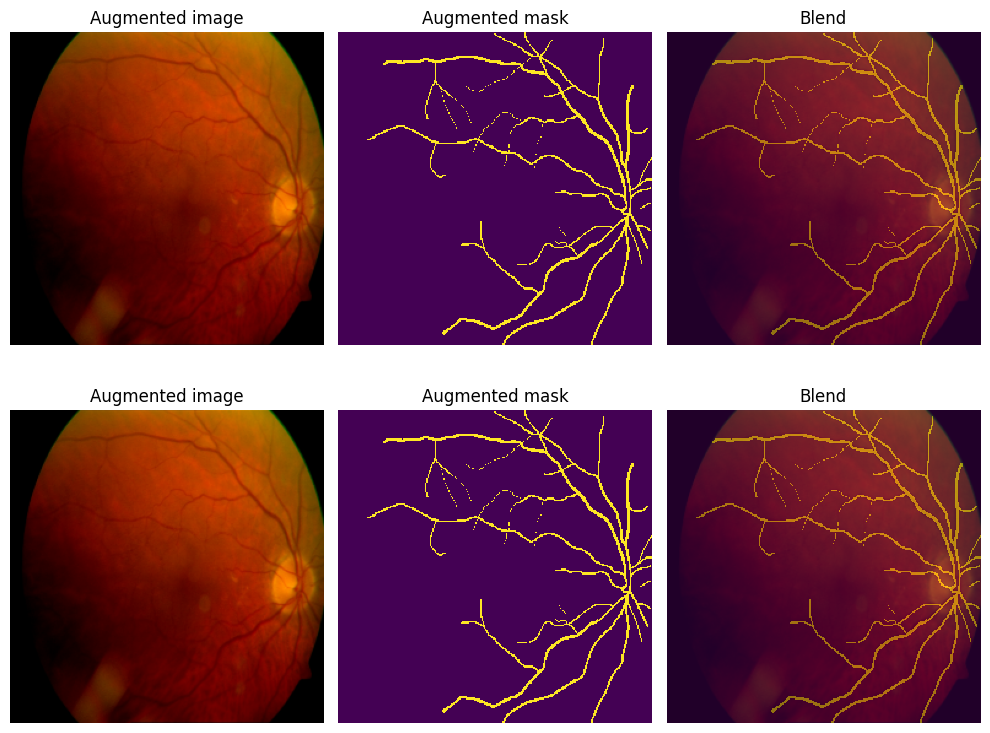

In [42]:
random.seed(42)
visualize_augmentations(train_dataset, idx=55)

In [61]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [12]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images).squeeze(1)
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
        torch.cuda.empty_cache()
    return metric_monitor.metrics['Loss']['avg']

In [13]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images).squeeze(1)
            loss = criterion(output, target)
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
            torch.cuda.empty_cache()
    return metric_monitor.metrics['Loss']['avg']

In [62]:
def create_model(params):
    model = getattr(ternausnet.models, params["model"])(pretrained=True)
    model = model.to(params["device"])
    return model

In [15]:
def train_and_validate(model, train_dataset, val_dataset, params):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    loss_list = [[],[]]
    # criterion = nn.BCEWithLogitsLoss().to(params["device"])
    criterion = DiceLoss(mode='binary').to(params["device"])
    optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"])
    for epoch in range(1, params["epochs"] + 1):
        m_t = train(train_loader, model, criterion, optimizer, epoch, params)
        m_v = validate(val_loader, model, criterion, epoch, params)
        loss_list[0].append(m_t)
        loss_list[1].append(m_v)

    fig, ax1 = plt.subplots(1, 1, sharex=True, layout="constrained")
    xepoch = np.arange(params['epochs'])+1
    ax1.plot(xepoch, loss_list[0], label='train')
    ax1.plot(xepoch, loss_list[1], label='valid')
    ax1.legend(loc="center right")
    ax1.set_ylabel('loss')
    
    # ax2.plot(xepoch, train_acc_list, label='train')
    # ax2.plot(xepoch, valid_acc_list, label='valid')
    # ax2.legend(loc="center right")
    # ax2.set_ylabel('accuracy')
    plt.plot()
    return model

In [16]:
model = create_model(params)

c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 35. Validation. Loss: 0.178: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]


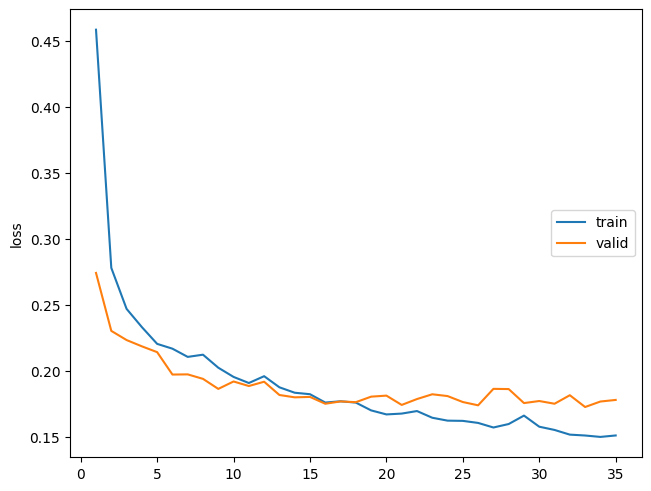

In [17]:
model = train_and_validate(model, train_dataset, val_dataset, params)

In [63]:
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            probabilities = probabilities.cpu().numpy()
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, probability, original_height, original_width in zip(
                predicted_masks, probabilities, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, probability, original_height, original_width))
    return predictions

In [64]:
class SegmInferenceDataset(Dataset):
    def __init__(self, images_paths, transform=None):
        self.images_paths = images_paths
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image_path = self.images_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, original_size

test_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.3998, 0.1676, 0.0636), std=(0.2762, 0.1356, 0.0666)), ToTensorV2()]
)
test_dataset = SegmInferenceDataset(test_images_paths, transform=test_transform,)

In [68]:
predictions = predict(model, params, test_dataset, batch_size=10)
predicted_masks = []
predicted_probabilities = []
for predicted_256x256_mask, probabilities_256x256, original_height, original_width in predictions:
    full_sized_mask = A.resize(
        predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )
    predicted_masks.append(full_sized_mask)
    full_sized_probability = A.resize(
        probabilities_256x256, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )
    predicted_probabilities.append(full_sized_probability)

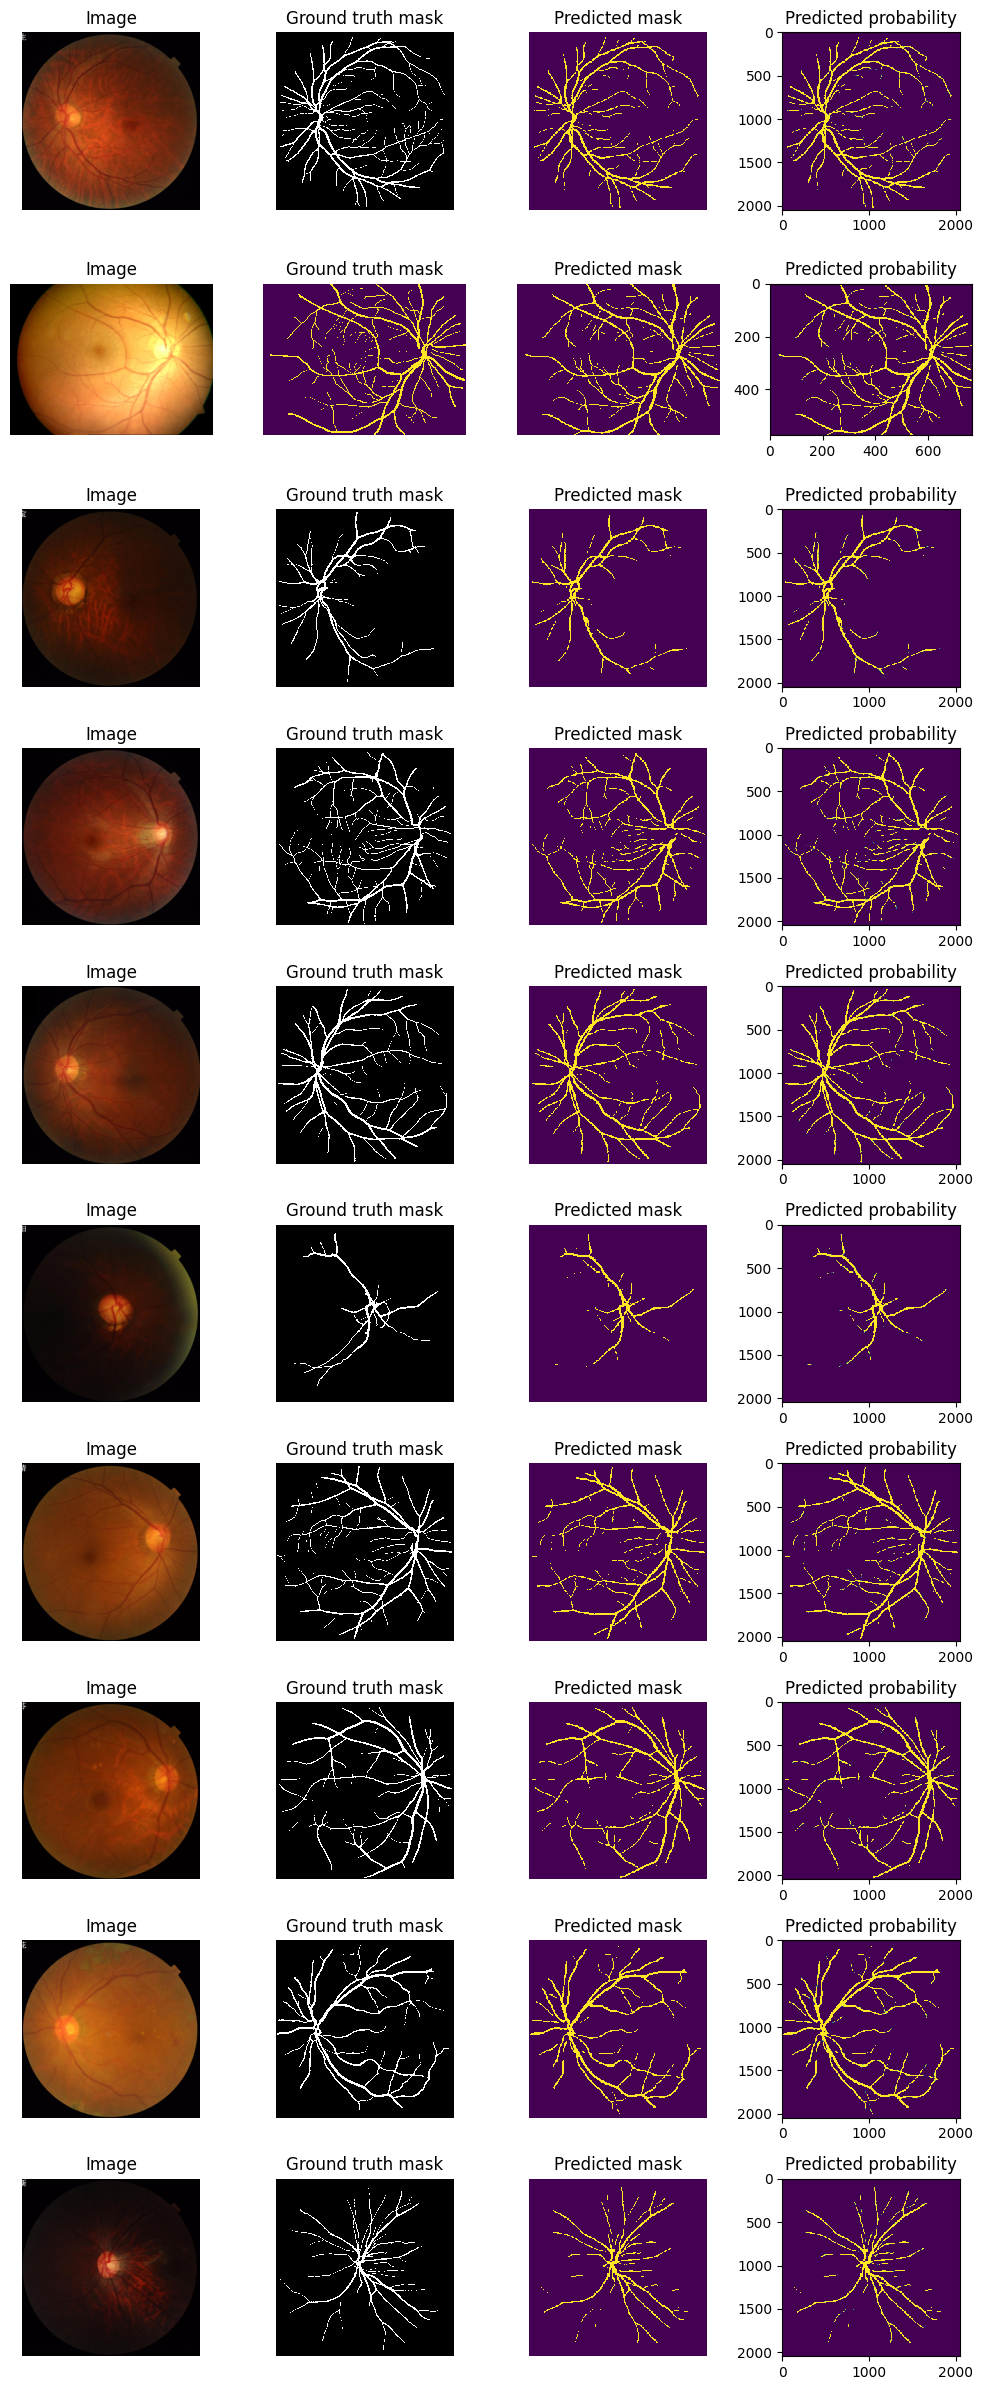

In [414]:
def paste_and_save(test_images_paths, predicted_masks, predicted_probabilities, save_img):
    for i, path in enumerate(test_images_paths):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h,w = image.shape[:2]
        image = PIL.Image.fromarray(image)

        mask_path = str(path).replace("/img\\", "/segm\\")
        if mask_path.split('\\')[-1][0] !='f' and (mask_path.split('\\')[-1].split('.')[-1] == 'jpg' or mask_path.split('\\')[-1].split('.')[-1] == 'JPG'):
            mask_path = mask_path.replace('.jpg', '.tif').replace('.JPG', '.tif')
        mask = cv2.imread(mask_path)
        mask = A.Resize(h,w)(image=mask)
        mask = PIL.Image.fromarray(mask["image"])

        predicted_mask = PIL.Image.fromarray(predicted_masks[i]*255)

        target = PIL.Image.new('RGB', (3 * w, h))
        target.paste(image, box = (0, 0))
        target.paste(mask, box = (w, 0))
        target.paste(predicted_mask, box = (2 * w, 0))
        target.save(os.path.join(save_img, 'result_{}.png'.format(path.split("\\")[-1])))

paste_and_save(test_images_paths, predicted_masks, predicted_probabilities, save_img='pred_img_Unet11')
display_image_grid(test_images_paths, predicted_masks=predicted_masks, predicted_probabilities=predicted_probabilities)

In [67]:
# nm_model = f'models/{model_name}prep_e{epochs_num}_s{img_size}_b{batch_size}_onlyjitter.pt'
# torch.save(model.state_dict(), nm_model)

# model = create_model(params)
# model.load_state_dict(torch.load('models/Unet11_e35_s256_b9_without_augm.pt'))

torch.cuda.empty_cache()